In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('words_alpha.txt', 'r').read().splitlines()


In [3]:
len(words)

370105

In [4]:
# build the vocabulary of characteres and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3
def build_dataset(words):
	X, Y = [], []
	for w in words:
		context = [0] * block_size
		for ch in w + '.':
			ix = stoi[ch]
			X.append(context)
			Y.append(ix)
			context = context[1:]+[ix]
	X = torch.tensor(X)
	Y = torch.tensor(Y)
	print(X.shape, Y.shape)
	return X, Y

In [6]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[:n2])

torch.Size([3092935, 3]) torch.Size([3092935])
torch.Size([385461, 3]) torch.Size([385461])
torch.Size([3478396, 3]) torch.Size([3478396])


In [7]:
Xtr[2], Ytr[2]

(tensor([ 0, 13,  9]), tensor(18))

In [10]:
# MLP
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) * (5/3)/(n_embed*block_size)**0.5
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g)*0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C,W1,W2,b2,bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
	p.requires_grad = True

12097


In [11]:
max_steps = 200000
batch_size = 32
lossi = []
 
for i in range(max_steps):

	ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
	Xb, Yb = Xtr[ix], Ytr[ix]
	emb = C[Xb]
	embcat = emb.view(emb.shape[0], -1)
	hpreact = embcat @ W1

	bnmeani = hpreact.mean(0, keepdim=True)
	bnstdi = hpreact.mean(0, keepdim=True)
	hpreact = bngain * (hpreact-bnmeani)/ bnstdi + bnbias
	with torch.no_grad():
		bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
		bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

	h = torch.tanh(hpreact)
	logits = h @ W2 + b2
	loss = F.cross_entropy(logits, Yb)

	for p in parameters:
		p.grad = None
	loss.backward()

	lr = 0.1 if i < 75000 else 0.01
	for p in parameters:
		p.data += -lr * p.grad

	if i%10000 == 0:
		print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())


      0 /  200000: 3.3072
  10000 /  200000: 2.4930
  20000 /  200000: 2.5759
  30000 /  200000: 2.4248
  40000 /  200000: 2.7524
  50000 /  200000: 2.8339
  60000 /  200000: 2.5794
  70000 /  200000: 2.2562
  80000 /  200000: 2.2831
  90000 /  200000: 2.5739
 100000 /  200000: 2.1541
 110000 /  200000: 2.3461
 120000 /  200000: 2.3808
 130000 /  200000: 2.5253
 140000 /  200000: 2.4421
 150000 /  200000: 2.1664
 160000 /  200000: 2.2357
 170000 /  200000: 2.0221
 180000 /  200000: 2.2661
 190000 /  200000: 2.2599


In [26]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2611050605773926
val 2.26265287399292


In [25]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors

      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

IndexError: index 29 is out of bounds for dimension 0 with size 27

In [45]:
# Training a deeper network

In [7]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [8]:
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

In [9]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [10]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
	Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	Linear(					n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	Linear(					n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	Linear(					n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	Linear(					n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	Linear(					n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)

]

In [11]:
with torch.no_grad():
	layers[-1].gamma *= 0.1
	for layer in layers[:-1]:
		if isinstance(layer, Linear):
			layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
	p.requires_grad = True

47024


In [12]:
max_steps = 20000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):
	ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
	Xb, Yb = Xtr[ix], Ytr[ix]

	emb = C[Xb]
	x = emb.view(emb.shape[0], -1)
	for layer in layers:
		x = layer(x)
	loss = F.cross_entropy(x, Yb)

	for layer in layers:
		layer.out.retain_grad()
	for p in parameters:
		p.grad = None
	loss.backward()

	lr = 0.1 if i < 15000 else 0.01
	for p in parameters:
		p.data += -lr * p.grad
	if i % 1000 == 0: # print every once in a while
		print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())
	with torch.no_grad():
		ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])



      0/  20000: 3.2881
   1000/  20000: 2.7165
   2000/  20000: 2.2604
   3000/  20000: 2.6594
   4000/  20000: 2.2676
   5000/  20000: 2.3562
   6000/  20000: 2.0973
   7000/  20000: 2.2211
   8000/  20000: 2.3848
   9000/  20000: 2.0136
  10000/  20000: 2.2497
  11000/  20000: 2.4896
  12000/  20000: 2.6384
  13000/  20000: 2.3553
  14000/  20000: 2.0238
  15000/  20000: 2.2834
  16000/  20000: 2.2214
  17000/  20000: 2.1426
  18000/  20000: 2.6138
  19000/  20000: 2.1091


layer 2 (      Tanh): mean +0.00, std 0.65, saturated: 5.31%
layer 5 (      Tanh): mean +0.01, std 0.68, saturated: 6.19%
layer 8 (      Tanh): mean +0.00, std 0.68, saturated: 5.91%
layer 11 (      Tanh): mean -0.01, std 0.68, saturated: 4.78%
layer 14 (      Tanh): mean -0.01, std 0.70, saturated: 4.53%


Text(0.5, 1.0, 'activation distribution')

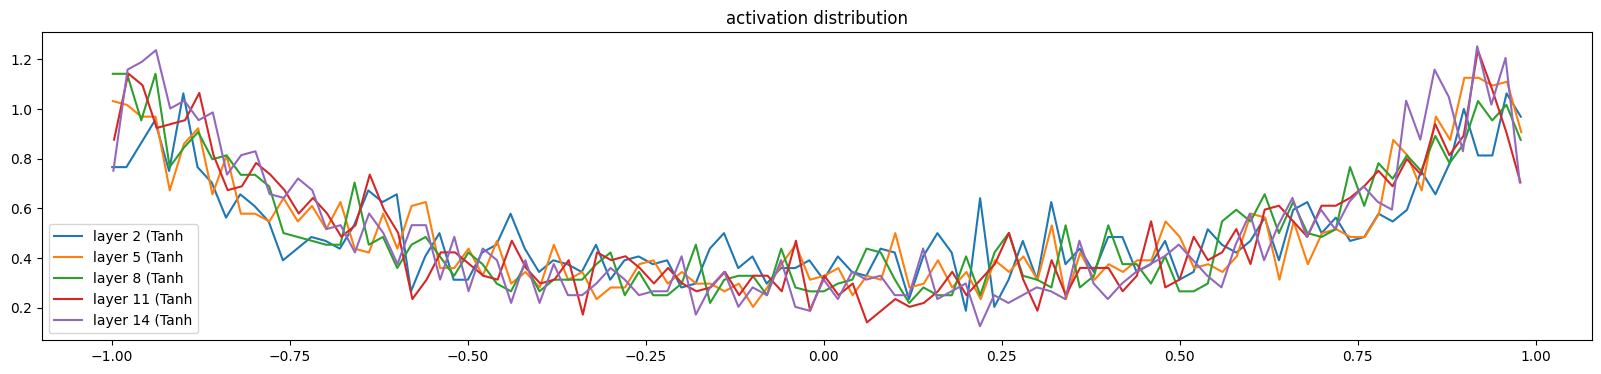

In [13]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.110738e-03
layer 5 (      Tanh): mean -0.000000, std 3.040929e-03
layer 8 (      Tanh): mean +0.000000, std 3.152739e-03
layer 11 (      Tanh): mean -0.000000, std 3.172867e-03
layer 14 (      Tanh): mean +0.000000, std 3.199332e-03


Text(0.5, 1.0, 'gradient distribution')

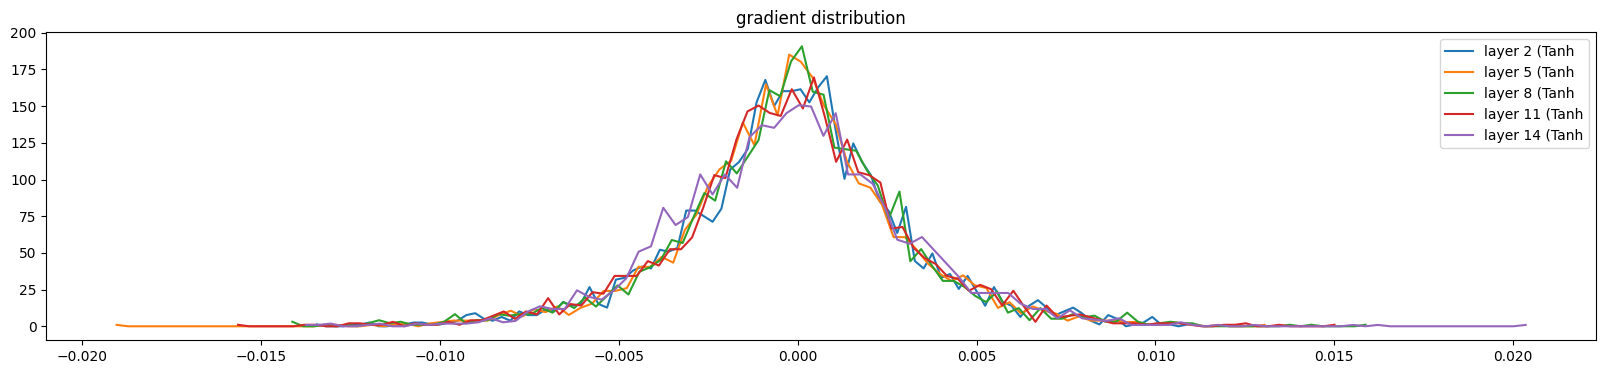

In [14]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.037556e-02 | grad:data ratio 1.026175e-02
weight  (30, 100) | mean +0.000018 | std 7.199138e-03 | grad:data ratio 2.185120e-02
weight (100, 100) | mean +0.000056 | std 5.519622e-03 | grad:data ratio 2.975801e-02
weight (100, 100) | mean -0.000020 | std 5.591650e-03 | grad:data ratio 3.025660e-02
weight (100, 100) | mean -0.000013 | std 5.454988e-03 | grad:data ratio 2.981208e-02
weight (100, 100) | mean +0.000014 | std 5.579053e-03 | grad:data ratio 3.076825e-02
weight  (100, 27) | mean -0.000050 | std 1.056032e-02 | grad:data ratio 4.938267e-02


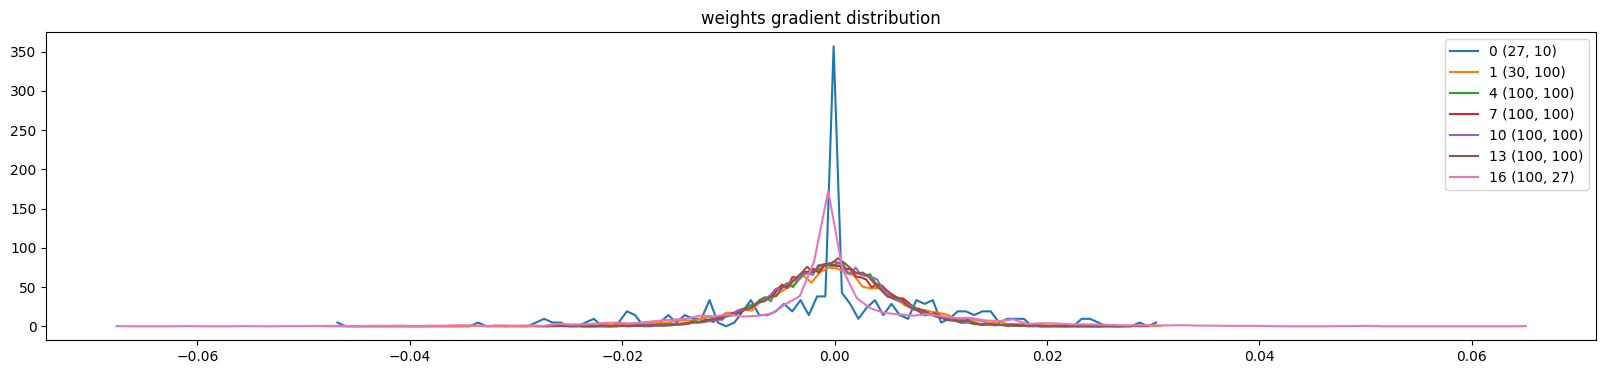

In [15]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

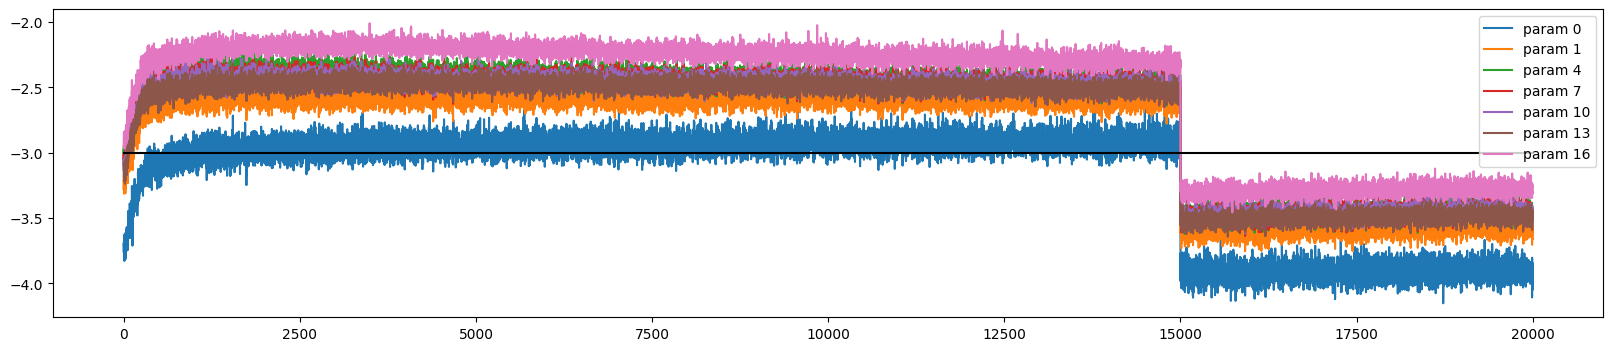

In [16]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

In [91]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mon.
ammyah.
see.
mad.
rylle.
emmastendraege.
zeredielin.
shi.
jen.
eden.
camana.
selynn.
houra.
noshubergihiriel.
kindrenelle.
nowucayubelled.
ruy.
julieh.
yuma.
mistouda.
